# Introduction


This notebook uses the openkmi package to calculate the Penman-Monteith evapotranspiration and the corresponding rainfall deficit.

# Initialize the package

First load the modules we will use

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd   
from openkmi.point_obs import Synop
import numpy as np
import pyeto
from pyeto import fao
import datetime
from owslib.fes import PropertyIsEqualTo

c:\programdata\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\programdata\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


Then initialize the package

In [2]:
kmi = Synop()

In [3]:
stations = kmi.get_stations().set_index('code')
stations = stations[~stations.index.duplicated(keep='first')]
stations['date_begin'] = pd.to_datetime(stations['date_begin'])
stations['date_end'] = pd.to_datetime(stations['date_end'])

stations = stations[stations['date_end'].isna()]
# stations = stations[stations['date_begin'] < datetime.datetime(2000,1,1)]

stations.sort_values(by='date_begin')
# stations[stations['date_begin'] < datetime.datetime(2000,1,1)]

,the_geom,altitude,name,date_begin,date_end
code,,,,,
6476,POINT (50.038875 5.403753),557.0,SAINT-HUBERT,1952-01-01 00:00:00,NaT
6451,POINT (50.896391 4.526765),58.0,ZAVENTEM/MELSBROEK,1952-01-01 00:00:00,NaT
6450,POINT (51.191399 4.451755),14.0,DEURNE,1952-01-01 00:00:00,NaT
6478,POINT (50.645282 5.458738),178.0,BIERSET,1952-01-01 00:00:00,NaT
6490,POINT (50.478615 5.909864),482.0,SPA (AERODROME),1952-01-01 00:00:00,NaT
6407,POINT (51.200341 2.887306),3.5,MIDDELKERKE,1955-01-01 00:00:00,NaT
6449,POINT (50.454432 4.442053),192.0,GOSSELIES,1962-01-01 00:00:00,NaT
6455,POINT (50.095445 4.59459),234.8,DOURBES,2000-02-08 03:00:00,NaT
6494,POINT (50.510779 6.073438),673.2,MONT RIGI,2001-04-12 00:00:00,NaT


Let's choose a station for which to do the analysis:

In [4]:
kmi.get_parameters()

{'code': 'int',
 'timestamp': 'dateTime',
 'precip_quantity': 'decimal',
 'precip_range': 'decimal',
 'temp': 'decimal',
 'temp_min': 'decimal',
 'temp_max': 'decimal',
 'temp_grass_min': 'decimal',
 'wind_speed': 'decimal',
 'wind_speed_unit': 'int',
 'wind_direction': 'decimal',
 'wind_peak_speed': 'decimal',
 'humidity_relative': 'decimal',
 'weather_current': 'int',
 'pressure': 'decimal',
 'pressure_station_level': 'decimal',
 'sun_duration_24hours': 'decimal',
 'short_wave_from_sky_24hours': 'decimal',
 'cloudiness': 'decimal'}

# Fetch rainfall data

In [5]:
df_l = []
for s in stations.index:
    custom_filt = PropertyIsEqualTo(propertyname='precip_range', literal='2')
    df_r = kmi.get_data(s, start_date=stations.loc[s, 'date_begin'].strftime('%Y-%m-%dT00:00:00'), end_date= datetime.datetime.now().strftime('%Y-%m-%dT00:00:00'),
                        parameter_list=['precip_quantity'], custom_filter=custom_filt)
    df_r = df_r[df_r.index.hour.isin([6,18])]
    df_r = df_r.resample('d').sum()
    # We assume values over 200mm / day are not realistic
    df_r.loc[df_r['precip_quantity'] > 200, 'precip_quantity']= 0
    df_r.columns = [s]
    df_l.append(df_r)
df_f_r = pd.concat(df_l, axis=1)

In [6]:
# Calculate mean rainfall over all stations
df_av_r = df_f_r.mean(axis=1)

# Calculate Penman-Monteith

We estimate reference evapotranspiration (ETo) from a hypothetical short grass reference surface using the FAO-56 Penman-Monteith equation. More info on the Penman-Monteith equation can be found here:

https://www.fao.org/3/x0490e/x0490e08.htm#TopOfPage

Inputting all the equations ourselves would take a lot of time. Luckily there is a nice package that we can use: pyeto:

https://pyeto.readthedocs.io/en/latest/


In [7]:
# This function uses pyeto to calculate the penman-monteith evp for Uccle
def get_montheith_evp(tmin, tmax, rh_min, rh_max, tmean, sunshine_hours, day_of_year, ws, short_wave_from_sky, altitude=100, lat=50.48):
    svp_tmin = pyeto.svp_from_t(tmin)
    svp_tmax = pyeto.svp_from_t(tmax)
    if not np.isnan(rh_max) and not np.isnan(rh_max):
        ea = pyeto.avp_from_rhmin_rhmax(svp_tmin, svp_tmax, rh_min, rh_max)
    else:
        # If RH not availble that we use tmin instead of RH
        ea = pyeto.avp_from_tmin(tmin)
    es = pyeto.mean_svp(tmin, tmax)
    sol_dec = pyeto.sol_dec(day_of_year)
    sha = pyeto.sunset_hour_angle(pyeto.deg2rad(lat), sol_dec)
    daylight_hours = pyeto.daylight_hours(sha)
    ird = pyeto.inv_rel_dist_earth_sun(day_of_year)
    et_rad = pyeto.et_rad(pyeto.deg2rad(lat), sol_dec, sha, ird)
    cs_rad = pyeto.cs_rad(pyeto.deg2rad(lat), et_rad)
    if np.isnan(short_wave_from_sky):
        # If not available: Use sunshine hours to calculatie
        if not np.isnan(sunshine_hours):
            sol_rad = pyeto.sol_rad_from_sun_hours(daylight_hours, sunshine_hours, et_rad)
        else:
            # If sunshine hours not available that we calculate it from temperature
            sol_rad = pyeto.sol_rad_from_t(et_rad, cs_rad, tmin, tmax, False)
    else:
        # When short_wave_from_sky available: Use this
        sol_rad = short_wave_from_sky
    ni_sw_rad = pyeto.net_in_sol_rad(sol_rad, albedo=0.23)
    no_lw_rad = pyeto.net_out_lw_rad(tmin +273.16, tmax + 273.16, sol_rad, cs_rad, ea)
    net_rad = pyeto.net_rad(ni_sw_rad, no_lw_rad)
    delta_svp = pyeto.delta_svp(tmean)
    psy = pyeto.psy_const(pyeto.atm_pressure(altitude))
    return float(pyeto.fao56_penman_monteith(net_rad, tmean+ 273.16, ws, es, ea, delta_svp, psy, shf=0.0))

In [8]:
df_l = []
for s in stations.index:
    df = kmi.get_data(s, start_date=stations.loc[s, 'date_begin'].strftime('%Y-%m-%dT00:00:00'), end_date= datetime.datetime.now().strftime('%Y-%m-%dT00:00:00'),
                        parameter_list=['temp', 'humidity_relative', 'wind_speed', 'sun_duration_24hours', 'pressure', 'short_wave_from_sky_24hours'])
    # Some RH's are larger than 100 which obviously is not possible:
    df.loc[df['humidity_relative'] > 100, 'humidity_relative'] = 100
    # Transform to daily mean, min and max values
    df_d = df.resample('d').mean()[['temp', 'wind_speed', 'sun_duration_24hours', 'short_wave_from_sky_24hours']]
    df_d['tmin'] = df.resample('d').min()['temp']
    df_d['tmax'] = df.resample('d').max()['temp']
    df_d['rh_min'] = df.resample('d').min()['humidity_relative']
    df_d['rh_max'] = df.resample('d').max()['humidity_relative']
    # Sun duration is in minutes while we need it in hours
    df_d['sun_duration_24hours'] = df_d['sun_duration_24hours'] / 60
    # From J to MJ
    df_d['short_wave_from_sky_24hours'] = df_d['short_wave_from_sky_24hours'] * 1e-6
    df_d['doy'] = df_d.index.dayofyear
    # Filling some "smaller" gaps
    for c in ['wind_speed', 'temp', 'tmin', 'tmax']:
        df_d[c] = df_d[c].interpolate() 
    df_d['evp'] = np.nan
    for i in df_d.index:
        df_d.loc[i, 'evp'] = get_montheith_evp(df_d.loc[i, 'tmin'], df_d.loc[i, 'tmax'], df_d.loc[i, 'rh_min'], df_d.loc[i, 'rh_max'], df_d.loc[i, 'temp'], 
                                               df_d.loc[i, 'sun_duration_24hours'], df_d.loc[i, 'doy'], df_d.loc[i, 'wind_speed'], df_d.loc[i, 'short_wave_from_sky_24hours'],
                                               altitude=stations.loc[s, 'altitude'], lat=float(stations.loc[s, 'the_geom'].split('(')[1].split(' ')[0]))
    tmp = df_d[['evp']]
    tmp.columns = [s]
    df_l.append(tmp)

In [9]:
df_pet = pd.concat(df_l, axis=1)
df_av_pet = df_pet.mean(axis=1)

# Calculate rainfall deficit

Now we have the rainfall and the evapotranspiration so we can calculate the rainfall deficit.

In [26]:
df_av_pet.name = 'evp'
df_av_r.name = 'precip_quantity'
df_f = pd.merge(df_av_r, df_av_pet, left_index=True, right_index=True)
df_f['neerslagtekort'] = df_f['evp'] - df_f['precip_quantity']

In [27]:
# Pivot the df so we can easily check the plot
df_f['year'] = df_f.index.year
df_f['doy'] = df_f.index.dayofyear
# df_dd = df_f.pivot(index='doy', columns='year', values='neerslagtekort')
df_dd = df_f.pivot(index='doy', columns='year', values='neerslagtekort')
# We sort of ignore the leap years for now
df_dd = df_dd.iloc[:-1,:]

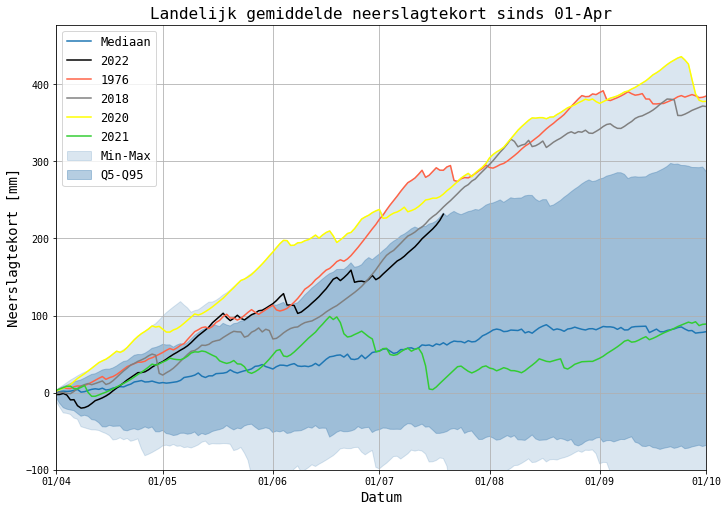

In [40]:
# Make a nice overview plot
plt.rcParams['font.family'] = 'MonoSpace'

fig, ax = plt.subplots(figsize=(10,7), constrained_layout=True)

# We start from april first in the plot which is doy: 91 (still neglecting leap years)
trunc = 91
xas = [datetime.datetime(2021, 1, 1) + datetime.timedelta(x - 1) for x in df_dd.index]
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().min(axis=1), df_dd.truncate(before=trunc).cumsum().max(axis=1), alpha=.2, color='steelblue')
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.05, axis=1), df_dd.truncate(before=trunc).cumsum().quantile(.95, axis=1), color='steelblue', alpha=.4)
ax.plot(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.5, axis=1))
ax.plot(xas[trunc-1:], df_dd[2022].truncate(before=trunc).cumsum(),  color='black')
ax.plot(xas[trunc-1:], df_dd[1976].truncate(before=trunc).cumsum(),  color='tomato')
ax.plot(xas[trunc-1:], df_dd[2018].truncate(before=trunc).cumsum(),  color='grey')
ax.plot(xas[trunc-1:], df_dd[2020].truncate(before=trunc).cumsum(),  color='yellow')
ax.plot(xas[trunc-1:], df_dd[2021].truncate(before=trunc).cumsum(),  color='limegreen')
ax.grid()
# ax.set_ylim([-100,500])
myFmt = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(myFmt)
ax.legend(['Mediaan', '2022', '1976', '2018', '2020',  '2021', 'Min-Max', 'Q5-Q95'], loc=2, fontsize=12)
ax.set_ylabel('Neerslagtekort [mm]', fontsize=14)
ax.set_xlabel('Datum', fontsize=14)
ax.set_title(f'Landelijk gemiddelde neerslagtekort sinds {xas[trunc-1].strftime("%d-%b")}', fontsize=16);
ax.set_xlim([xas[trunc-1], datetime.datetime(2021,10,1)])
ax.set_ylim([-100, None]);

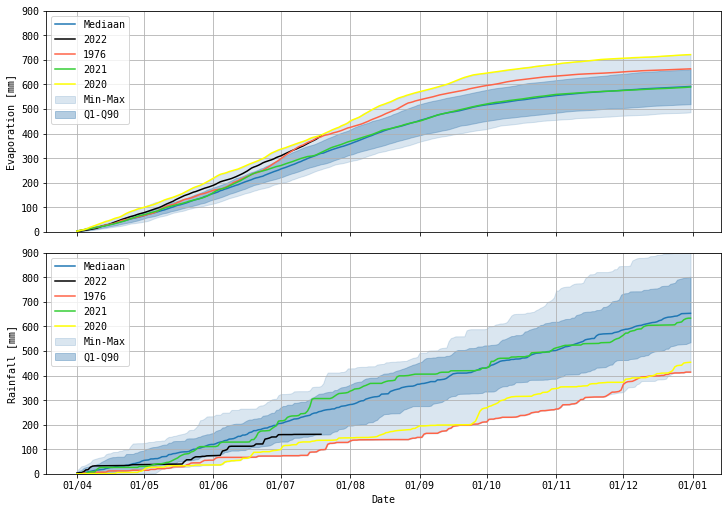

In [13]:
# Split the rainfall and evaporation component
plt.rcParams['font.family'] = 'MonoSpace'
# Fist evaporation
df_dd = df_f.pivot(index='doy', columns='year', values='evp')
# We sort of ignore the leap years for now
df_dd = df_dd.iloc[:-1,:]
fig, axx = plt.subplots(figsize=(10,7), nrows=2, constrained_layout=True, sharex=True)

ax = axx[0]
trunc = 91
xas = [datetime.datetime(2021, 1, 1) + datetime.timedelta(x - 1) for x in df_dd.index]
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().min(axis=1), df_dd.truncate(before=trunc).cumsum().max(axis=1), alpha=.2, color='steelblue')
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.1, axis=1), df_dd.truncate(before=trunc).cumsum().quantile(.9, axis=1), color='steelblue', alpha=.4)
ax.plot(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.5, axis=1))
ax.plot(xas[trunc-1:], df_dd[2022].truncate(before=trunc).cumsum(),  color='black')
ax.plot(xas[trunc-1:], df_dd[1976].truncate(before=trunc).cumsum(),  color='tomato')
ax.plot(xas[trunc-1:], df_dd[2021].truncate(before=trunc).cumsum(),  color='limegreen')
ax.plot(xas[trunc-1:], df_dd[2020].truncate(before=trunc).cumsum(),  color='yellow')
ax.grid()
ax.set_ylim([0,900])
myFmt = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(myFmt)
ax.legend(['Mediaan', '2022', '1976', '2021', '2020', 'Min-Max', 'Q1-Q90'], loc=2)
ax.set_ylabel('Evaporation [mm]')
# ax.set_title(stations.loc[station_code, 'name'])

# Then rainfall
df_dd = df_f.pivot(index='doy', columns='year', values='precip_quantity')
df_dd = df_dd.iloc[:-1,:]
ax = axx[1]
xas = [datetime.datetime(2021, 1, 1) + datetime.timedelta(x - 1) for x in df_dd.index]
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().min(axis=1), df_dd.truncate(before=trunc).cumsum().max(axis=1), alpha=.2, color='steelblue')
ax.fill_between(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.1, axis=1), df_dd.truncate(before=trunc).cumsum().quantile(.9, axis=1), color='steelblue', alpha=.4)
ax.plot(xas[trunc-1:], df_dd.truncate(before=trunc).cumsum().quantile(.5, axis=1))
ax.plot(xas[trunc-1:], df_dd[2022].truncate(before=trunc).cumsum(),  color='black')
ax.plot(xas[trunc-1:], df_dd[1976].truncate(before=trunc).cumsum(),  color='tomato')
ax.plot(xas[trunc-1:], df_dd[2021].truncate(before=trunc).cumsum(),  color='limegreen')
ax.plot(xas[trunc-1:], df_dd[2020].truncate(before=trunc).cumsum(),  color='yellow')
ax.grid()
ax.set_ylim([0,900])
myFmt = mdates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(myFmt)
ax.legend(['Mediaan', '2022', '1976', '2021', '2020', 'Min-Max', 'Q1-Q90'], loc=2)
ax.set_ylabel('Rainfall [mm]')
ax.set_xlabel('Date');

Note that the plots do not fully correspond to the "official" plots made by Patrick Willems. Differences might be due to:
* Inconsistencies in the data (both availability and quality)
* Inconsistencies in the calculation method being used

# Distribution
How is the spatial distribution of the rainfall deficit across the country?

In [14]:
stations['tekort'] = np.nan
for s in stations.index:
    stations.loc[s, 'tekort'] = df_pet[s].truncate(before='2022-04-01').sum() - df_f_r[s].truncate(before='2022-04-01').sum()

c:\programdata\anaconda3\lib\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


In [15]:
import geopandas

In [16]:
stations['y'] = [x.split('(')[-1].split(' ')[0] for x in stations['the_geom']]
stations['x'] = [x.split('(')[-1].split(' ')[-1][:-1] for x in stations['the_geom']]

In [17]:
gdf = geopandas.GeoDataFrame(stations, geometry=geopandas.points_from_xy(stations.x, stations.y), crs=4326)

In [18]:
gdf = gdf.to_crs(31370)

In [41]:
provs = geopandas.read_file("data/province_3812.shp")

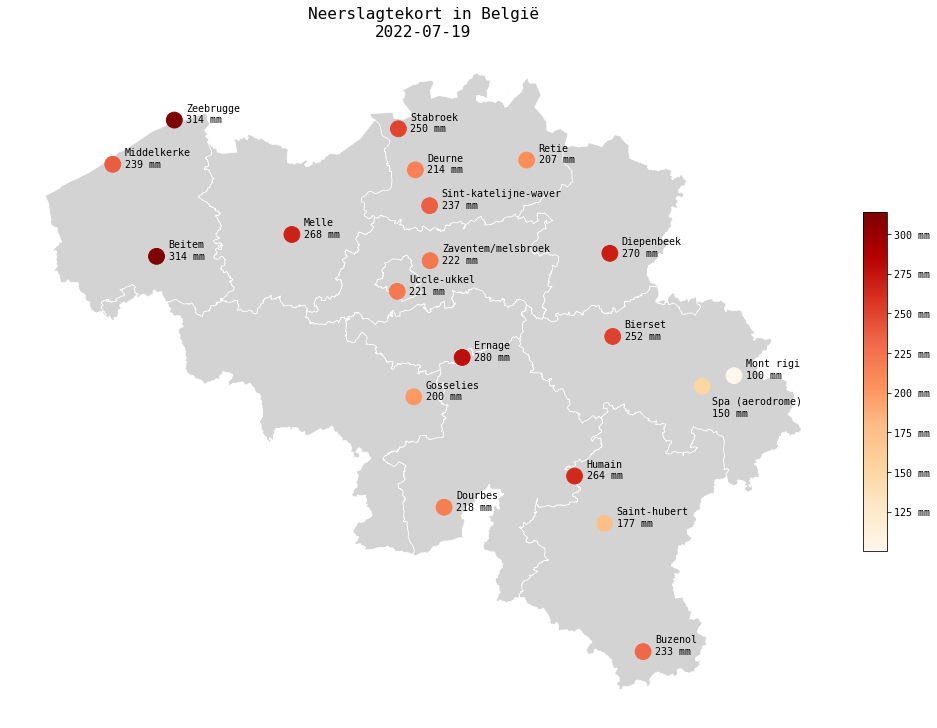

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['axes.labelsize'] = 'x-large'
fig, ax = plt.subplots(figsize=(14,10), constrained_layout=True)
provs.to_crs(31370).plot(facecolor="lightgrey", edgecolor='white', lw=0.7, ax=ax)
gdf.plot(column='tekort', cmap='OrRd', ax=ax, legend=True, s=250, legend_kwds={'shrink':0.5, 'format': '%.0f mm'})
for x, y, tekort, name in zip(gdf.geometry.x, gdf.geometry.y, gdf.tekort, gdf.name):
    if 'SPA' in name:
        ax.annotate(f'{name.capitalize()}\n{int(round(tekort, 0))} mm', xy=(x, y), xytext=(10, -30), textcoords="offset points", color='black')
    else:
        ax.annotate(f'{name.capitalize()}\n{int(round(tekort, 0))} mm', xy=(x, y), xytext=(12, -3), textcoords="offset points", color='black')
ax.set_title('')
ax.set_axis_off()
ax.set_title(f'Neerslagtekort in België\n{df_pet.last_valid_index().strftime("%Y-%m-%d")}', fontsize=16)
plt.savefig('Neerslagtekort.png')